<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/02_Vision/PTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PTI

## 0. Info

### Paper
* title: Pivotal Tuning for Latent-based Editing of Real Images
* author: Daniel Roich et al.
* url: https://arxiv.org/abs/2106.05744

### Features
* dataset: ffhq-subset

### Reference
* https://github.com/danielroich/PTI

## 1. Setup

In [ ]:
# prepare
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!cp -r stylegan2-ada-pytorch/torch_utils .
!cp -r stylegan2-ada-pytorch/dnnlib .

# pretrained model
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl # FFHQ StyleGAN2

# Interface GAN direction
!wget https://raw.githubusercontent.com/danielroich/PTI/main/editings/interfacegan_directions/age.pt
!wget https://raw.githubusercontent.com/danielroich/PTI/main/editings/interfacegan_directions/smile.pt
!wget https://raw.githubusercontent.com/danielroich/PTI/main/editings/interfacegan_directions/rotation.pt

In [ ]:
!pip install -q lpips ninja

In [1]:
import os
import pickle
import easydict
import numpy as np
from PIL import Image
from glob import glob
from tqdm.auto import tqdm

import lpips
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

In [2]:
cfg = easydict.EasyDict(
    dataset = 'ffhq-1024-subset',

    num_inversion_steps = 450,
    num_tuning_steps = 350,
    local_regularization = True,

    device = 'cuda',
    dataset_dir = '/content/drive/Shareddrives/dataset',
)

## 2. Data

In [3]:
def image_to_tensor(img, img_size=None):
    size = (img_size, img_size) if img_size else (img.height, img.width)
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    return transform(img)

def tensor_to_image(tensor):
    image = (tensor.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()
    return Image.fromarray(image)

def get_image_from_ws(G, ws, size=None):
    with torch.no_grad():
        out = G.synthesis(ws, noise_mode='const')[0]
    out = tensor_to_image(out)
    if size:
        out = T.Resize(size)(out)
    return out

In [8]:
data_path = os.path.join(cfg.dataset_dir, f'{cfg.dataset}.zip')
!unzip -q "{data_path}" -d 'data'

In [4]:
files = glob('data/images/*.png')
f = np.random.choice(files)
image = Image.open(f)

## 3. Train

### 3.1. Inversion

In [5]:
def project(
    G, target, device, 
    num_w_samples=1000, num_steps=1000,
    initial_learning_rate = 0.01, lr_rampdown_length = 0.25, lr_rampup_length = 0.05,
    initial_noise_factor = 0.05, noise_ramp_length = 0.75, lambda_reg = 1
):
    if len(target.size()) == 3:
        target = target.unsqueeze(0)
    img_size = target.size(-1)
    _ = G.requires_grad_(False)
    
    z_samples = torch.randn(num_w_samples, G.z_dim).to(device)
    w_samples = G.mapping(z_samples, None)
    w_samples = w_samples[:, :1, :] # (num w sample, 1, dim)
    w_avg = torch.mean(w_samples, dim=0, keepdims=True) # (1, 1, dim)
    w_std = (torch.sum((w_samples - w_avg) ** 2) / num_w_samples) ** 0.5
    
    w_opt = w_avg.clone().requires_grad_(True)
    noise_bufs = {name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name}
    params = [w_opt] + list(noise_bufs.values())
    optimizer = torch.optim.Adam(params, betas=(0.9, 0.999), lr=5e-3)
    
    # Init noise.
    with torch.no_grad():
        for buf in noise_bufs.values():
            buf[:] = torch.randn_like(buf)
            buf.requires_grad = True
        
    pbar = tqdm(range(num_steps))
    for st in pbar:
        # Learning rate scheduler
        t = st / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # LPIPS loss
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        gen = G.synthesis(ws, noise_mode='const', force_fp32=True)
        if gen.size(2) > img_size:
            gen = F.interpolate(gen, size=(img_size, img_size), mode='area')
        loss_lpips = lpips_loss_fn(gen, target).mean()
#         loss_recon = F.mse_loss(gen, target)

        # Noise regularization loss
        loss_reg = 0.0
        for v in noise_bufs.values():
            noise = v[None, None, :, :]  # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                loss_reg += (noise * torch.roll(noise, shifts=1, dims=3)).mean() ** 2
                loss_reg += (noise * torch.roll(noise, shifts=1, dims=2)).mean() ** 2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Total loss
#         loss = loss_recon + loss_lpips + lambda_reg * loss_reg
        loss = loss_lpips + lambda_reg * loss_reg 

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
                
    return w_opt

In [6]:
G = pickle.load(open('ffhq.pkl', 'rb'))['G_ema'].requires_grad_(False).to(cfg.device).float().eval()

In [7]:
lpips_loss_fn = lpips.LPIPS(net='vgg').to(cfg.device).eval()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


In [8]:
tensor = image_to_tensor(image, img_size=512)
target = tensor.to(cfg.device)
w_opt = project(G, target, cfg.device, num_steps=cfg.num_inversion_steps)
w_pivot = w_opt.repeat(1, G.num_ws, 1).detach()

Setting up PyTorch plugin "bias_act_plugin"... Done.


  0%|          | 0/450 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


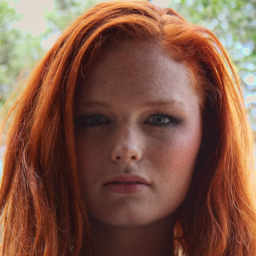

In [9]:
# real
T.Resize(256)(image)

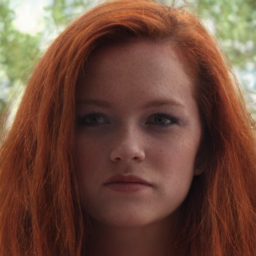

In [10]:
# inverted
get_image_from_ws(G, w_pivot, size=256)

### 3.2. Pivotal tuning

In [11]:
def localreg_loss_fn(G, newG, w_pivot, num_zs=1, alpha=30, lambda_lpips=0.1, lambda_l2=0.1):
    device = w_pivot.device
    zs = torch.randn(num_zs, G.z_dim).to(device)
    ws = G.mapping(zs, None, truncation_psi=0.5)
    direction = F.normalize(ws - w_pivot, dim=2, p=2)
    w_reg = w_pivot + alpha * direction
    
    out = G.synthesis(w_reg)
    newout = newG.synthesis(w_reg)
    loss = lambda_lpips * lpips_loss_fn(newout, out).squeeze() + lambda_l2 * F.mse_loss(newout, out)
    return loss

In [12]:
newG = pickle.load(open('ffhq.pkl', 'rb'))['G_ema'].requires_grad_(True).to(cfg.device).float()
optimizer = torch.optim.Adam(newG.parameters(), lr=3e-4)

In [13]:
tensor = image_to_tensor(image)
target = tensor.to(cfg.device).unsqueeze(0)

In [14]:
pbar = tqdm(range(cfg.num_tuning_steps))
for st in pbar:
    out = newG.synthesis(w_pivot)
    
    loss_l2 = F.mse_loss(out, target)
    loss_lpips = lpips_loss_fn(out, target).squeeze()
    if cfg.local_regularization:
        loss_reg = localreg_loss_fn(G, newG, w_pivot)
    else:
        loss_reg = 0.
    loss = loss_l2 + loss_lpips + loss_reg
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_postfix({'loss': loss.item()})

  0%|          | 0/350 [00:00<?, ?it/s]

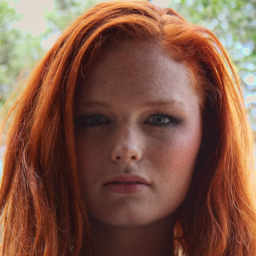

In [15]:
# real
T.Resize(256)(image)

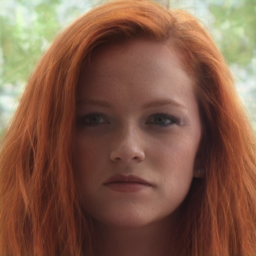

In [16]:
# inverted
get_image_from_ws(newG, w_pivot, size=256)

## 4. Test

In [17]:
feats = ['age', 'smile', 'rotation']
feat2dir = {f: torch.load(f'{f}.pt').unsqueeze(1).to(cfg.device) for f in feats}

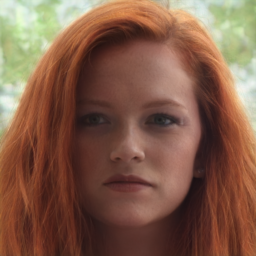

In [18]:
# inverted
get_image_from_ws(newG, w_pivot, size=256)

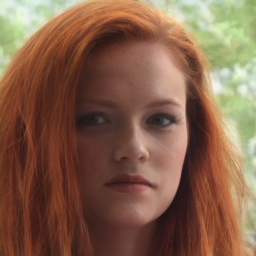

In [19]:
# edited rotation
get_image_from_ws(newG, w_pivot + -2*feat2dir['rotation'], size=256)

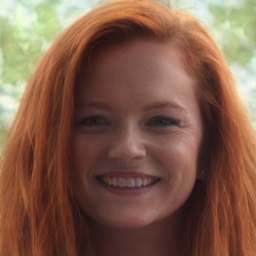

In [20]:
# edited smile
get_image_from_ws(newG, w_pivot + 2*feat2dir['smile'], size=256)

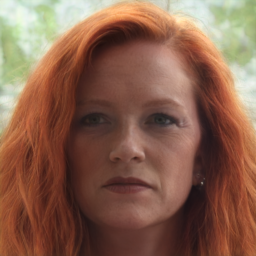

In [21]:
# edited age
get_image_from_ws(newG, w_pivot + 2*feat2dir['age'], size=256)